# Trump, Twitter, and Text: Data100
In this project, we will work with the Twitter API in order to analyze Donald Trump's tweets.

**This is a project from Data100 (Fall, 2020). It may contain outdated data and/or analysis.**

In [1]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import tweepy
import datetime
from pathlib import Path
import json

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

## Part I) Downloading Recent Tweets
Download recent Tweets from Twitter using the 'tweepy' package

In [2]:
key_file = 'keys.json'
with open(key_file) as f:
    keys = json.load(f)

In [3]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk."""

    keys = None
    with open(path) as f:
        keys = json.load(f)
    return keys 

In [4]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user."""
    import tweepy
    
    try:
        auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
        auth.set_access_token(keys["access_token"], keys["access_token_secret"])
        api = tweepy.API(auth)
    except TweepError as e:
        logging.warning("There was a Tweepy error. Double check your API keys and try again.")
        logging.warning(e)
    
    tweet_list = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, 
                                             tweet_mode='extended').items()]
    
    return tweet_list

In [5]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem."""
    with open(path, "w") as f:        
        json.dump(tweets, f)


In [6]:
def load_tweets(path):
    """Loads tweets that have previously been saved."""
    
    tweets = None
    with open(path, "r") as f:
        tweets = json.load(f)
    
    return tweets

In [7]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available."""
    
    keys = load_keys(keys_path)
    tweets = None
    
    #If the file does not exist
    if not Path(user_account_name + '.json').is_file():
        tweets = download_recent_tweets_by_user(user_account_name, keys)
        save_tweets(tweets, user_account_name + '.json')
    else:
        tweets = load_tweets(user_account_name + '.json')
    
    return tweets

In [8]:
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 1233


## Part II) Clean Data

Twitter prevent us from going further back in time using the public APIs, so combine snapshot of earlier tweets to combine with our new data.  

We will again use the `fetch_and_cache` utility to download the dataset. 

In [9]:
# Download the dataset
from utils import fetch_and_cache
data_url = 'http://www.ds100.org/sp18/assets/datasets/old_trump_tweets.json.zip'
file_name = 'old_trump_tweets.json.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Fri Jan 27 13:21:10 2023
MD5 hash of file: d9419cad17e76c87fe646b587f6e8ca5
Located at data\old_trump_tweets.json.zip


In [10]:
my_zip = zipfile.ZipFile(dest_path, 'r')
with my_zip.open("old_trump_tweets.json", "r") as f:
    old_trump_tweets = json.load(f)

In [11]:
pprint(old_trump_tweets[0])

Pretty printing has been turned OFF


In [12]:
old_trump_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

### Part II.a) Merge recent and old tweets 

Merge the `old_trump_tweets` and the `trump_tweets` we downloaded from twitter into one list of tweets. 

In [13]:
all_tweets = old_trump_tweets.copy()

setofid = set()
for tweet in old_trump_tweets:
    setofid.add(tweet['id'])

for tweet in trump_tweets:
    if tweet['id'] not in setofid:
        all_tweets.append(tweet)

In [14]:
assert len(all_tweets) > len(trump_tweets)
assert len(all_tweets) > len(old_trump_tweets)

### Part II.b) Convert data into a DataFrame

In [15]:
cols = [[pd.to_datetime(i['created_at']),i['source'],(i['text'] if 'text' in i.keys() else i['full_text']) ,i['retweet_count']] for i in all_tweets]
trump = pd.DataFrame(data=cols, columns=["time","source","text","retweet_count"],index=[i['id'] for i in all_tweets])
trump['time'] = pd.to_datetime(trump.time).dt.tz_localize(None)

In [16]:
assert isinstance(trump, pd.DataFrame)
assert trump.shape[0] < 8000
assert trump.shape[1] >= 4
assert 831846101179314177 in trump.index
assert 753063644578144260 in trump.index
assert all(col in trump.columns for col in ['time', 'source', 'text', 'retweet_count'])
# If you fail these tests, you probably tried to use __dict__ or _json to read in the tweets
assert np.sometrue([('Twitter for iPhone' in s) for s in trump['source'].unique()])
assert trump['time'].dtype == np.dtype('<M8[ns]')
assert trump['text'].dtype == np.dtype('O')
assert trump['retweet_count'].dtype == np.dtype('int64')

## Part III) Tweet Source Analysis

Analyze the charateristics of Trump tweets and the devices used for the tweets.

In [17]:
trump['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>'],
      dtype=object)

In [18]:
trump['source'] = trump['source'].str.replace(r"<[^>]*>","")

C:\Users\Kenta Sakai\AppData\Local\Temp\ipykernel_15552\284111813.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  trump['source'] = trump['source'].str.replace(r"<[^>]*>","")


In [19]:
from datetime import datetime
ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)
assert set(trump[(trump['time'] > ELEC_DATE) & (trump['time'] < INAUG_DATE) ]['source'].unique()) == set(['Twitter Ads',
 'Twitter Web Client',
 'Twitter for Android',
 'Twitter for iPhone'])

### III.a) Tweet behavior across devices

In [20]:
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,est_time
786204978629185536,2016-10-12 14:00:48,Twitter for iPhone,PAY TO PLAY POLITICS. \n#CrookedHillary https:...,24915,2016-10-12 09:00:48-05:00
786201435486781440,2016-10-12 13:46:43,Twitter for iPhone,Very little pick-up by the dishonest media of ...,22609,2016-10-12 08:46:43-05:00
786189446274248704,2016-10-12 12:59:05,Twitter for Android,Crooked Hillary Clinton likes to talk about th...,18329,2016-10-12 07:59:05-05:00
786054986534969344,2016-10-12 04:04:47,Twitter for iPhone,Thank you Florida- a MOVEMENT that has never b...,18789,2016-10-11 23:04:47-05:00
786007502639038464,2016-10-12 00:56:06,Twitter for iPhone,Join me Thursday in Florida &amp; Ohio!\nWest ...,7761,2016-10-11 19:56:06-05:00


<AxesSubplot:>

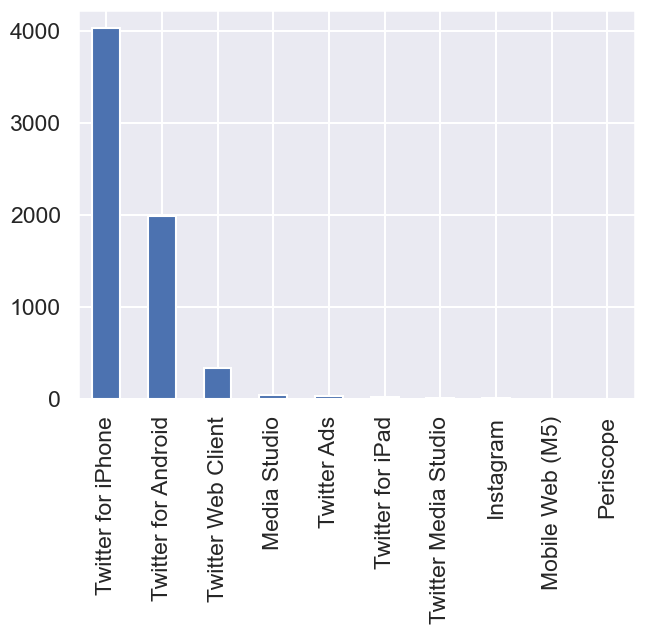

In [21]:
trump['hour'] = trump['est_time'].apply(lambda x: x.hour + (x.minute/60) + (x.second/3600))
trump['source'].value_counts().plot(kind="bar")

### III.b) Tweet distribution by device

C:\Users\Kenta Sakai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Kenta Sakai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


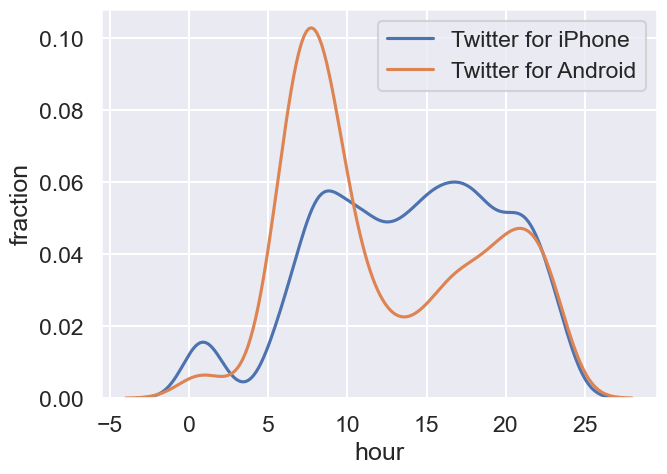

In [22]:
hours_android = trump[trump['source'] == 'Twitter for Android']['hour']
hours_iphone = trump[trump['source'] == 'Twitter for iPhone']['hour']
sns.distplot(hours_iphone, hist=False, label="Twitter for iPhone")
sns.distplot(hours_android, hist=False, label="Twitter for Android")
plt.ylabel("fraction")
plt.legend()

> Trump tends to Tweet more using Android in the morning, and iPhone in the afternoon. His Android tweet distribution drops sharply after 10 o'clock EST.

## Part IV) Device Analysis

Analyze which device he has used over the entire time period of this dataset.

In [23]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

trump['year'] = trump['time'].apply(year_fraction)

### IV.a) Plot device distribution over year 

C:\Users\Kenta Sakai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Kenta Sakai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


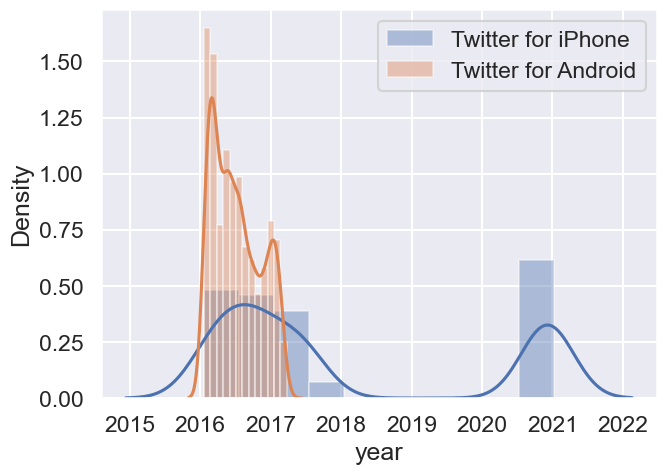

In [24]:
year_iphone = trump[trump['source'] == 'Twitter for iPhone']['year']
year_android = trump[trump['source'] == 'Twitter for Android']['year']
sns.distplot(year_iphone, label='Twitter for iPhone')
sns.distplot(year_android, label='Twitter for Android')
plt.legend()

### IV.b)
According to the plot, Trump's tweets come from many different sources. It turns out that many of his tweets were not from Trump himself but from his staff. [Take a look at this Verge article.](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android)

Does the data support the information in the article? What else do you find out about changes in Trump's tweets sources from the plot?

> Before the election, Trump tweeted much more often than now using his preferred device, Android. After the election, his total activity on the website decreased considerably. The curious thing is that his iPhone tweet distribution has barely changed pre and post-election, which may mean that most of his Tweets nowadays are actually from his staff.

## Part V) Sentiment Analysis

Use the vader lexicon to map polarity scores on his Tweets.

In [25]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



### V.a) Data Cleaning

In [26]:
sent = pd.read_table("vader_lexicon.txt", index_col=0, usecols=[0,1], names=["token", "polarity"])
trump['text'] = trump['text'].str.lower()

In [27]:
# Remove punctuation
punct_re = r'[^a-z \n0-9]'
trump['no_punc'] = trump['text'].str.replace(punct_re, " ")

C:\Users\Kenta Sakai\AppData\Local\Temp\ipykernel_15552\2551667022.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  trump['no_punc'] = trump['text'].str.replace(punct_re, " ")


### V.b) Reformat Data

In [28]:
tidy_format = pd.DataFrame(data=trump['no_punc'].str.split(expand=True))
tidy_format = tidy_format.stack().reset_index().set_index('level_0')
tidy_format.columns = ['num','word']
tidy_format.index.name = ''

### V.c) Calculate polarity

In [29]:
trump['polarity'] = tidy_format.join(sent, on='word').groupby(by=tidy_format.index.name).sum()['polarity']

In [30]:
assert np.allclose(trump.loc[744701872456536064, 'polarity'], 8.4)
assert np.allclose(trump.loc[745304731346702336, 'polarity'], 2.5)
assert np.allclose(trump.loc[744519497764184064, 'polarity'], 1.7)
assert np.allclose(trump.loc[894661651760377856, 'polarity'], 0.2)
assert np.allclose(trump.loc[894620077634592769, 'polarity'], 5.4)
# If you fail this test, you dropped tweets with 0 polarity
assert np.allclose(trump.loc[744355251365511169, 'polarity'], 0.0)

In [31]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   swing states that have found massive voter fraud, which is all of them, cannot legally certify these votes as complete &amp; correct without committing a severely punishable crime. everybody knows that dead people, below age people, illegal immigrants, fake signatures, prisoners,....

   wrong! at first they voted against because there were far more votes than people (sad!). then they were threatened, screamed at and viciously harassed, and were forced to change their vote, but then refused, as american patriots, to sign the documents. 71% mess. don’t harass! https://t.co/n5frpeshfd

   "@fiiibuster: @jeffzeleny pathetic - you have no sufficient evidence that donald trump did not suffer from voter fraud, shame! bad reporter.

   democrat jon ossoff would be a disaster in congress. very weak on crime and illegal immigration, bad for jobs and wants higher taxes. say no

   if a democrat presidential candidate had an election rigged &amp; stolen, with proof of su

In [32]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   thank you to linda bean of l.l.bean for your great support and courage. people will support you even more now. buy l.l.bean. @lbperfectmaine

   it is my great honor to announce that general michael t. flynn has been granted a full pardon. congratulations to @genflynn and his wonderful family, i know you will now have a truly fantastic thanksgiving!

   will be going to georgia for a big trump rally in support of our two great republican senators, david and kelly. they are fantastic people who love their country and love their state. we must work hard and be sure they win. #usa

   rt @ivankatrump: 2016 has been one of the most eventful and exciting years of my life. i wish you peace, joy, love and laughter. happy new…

   if the supreme court shows great wisdom and courage, the american people will win perhaps the most important case in history, and our electoral process will be respected again!


### V.d) Plot polarity

Plot the distribution of tweet sentiments broken down by whether the text of the tweet contains `nyt` or `fox`.  Then in the box below comment on what we observe?

C:\Users\Kenta Sakai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Kenta Sakai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


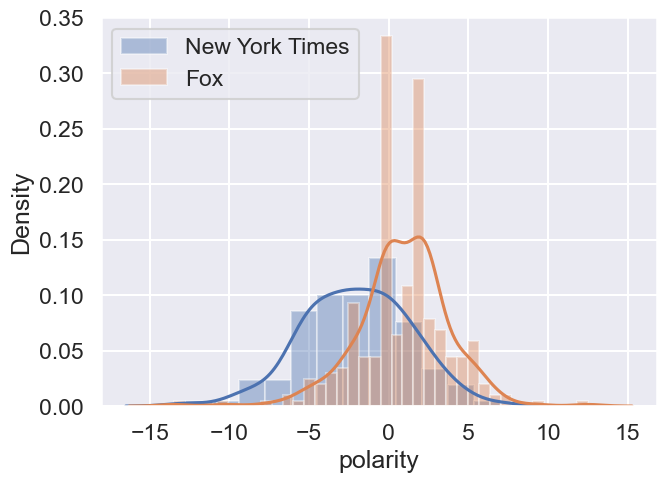

In [33]:
contains_nyt = trump[trump['text'].str.contains('nyt')]['polarity']
contains_fox = trump[trump['text'].str.contains('fox')]['polarity']
sns.distplot(contains_nyt, label="New York Times")
sns.distplot(contains_fox, label="Fox")
plt.legend()

> **Tweets that mention FOX are centered around postive polarity, meaning they are much more positive in context when compared to mentions of New York Times.**

## Part VI) Engagement
Find out which keywords had the most retweets

In [34]:
atleast25word = tidy_format.groupby('word').count()
atleast25word = atleast25word['num'] >= 25
top_20 = tidy_format.join(trump, on=trump.index.name)[['word','retweet_count']].groupby('word').median()[atleast25word].sort_values('retweet_count', ascending=False).iloc[:20]

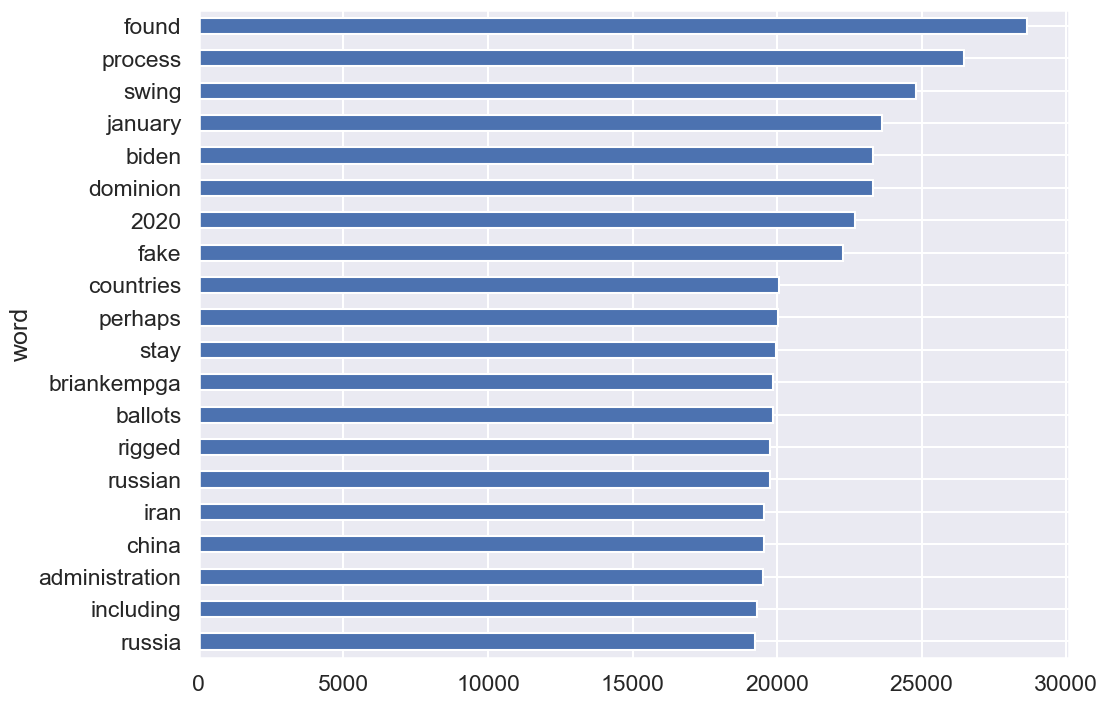

In [35]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

> * The phrase 'fake' is really popular and had many retweets (in 2020).
> * Another popular keyword in Biden in 2022 is 'Biden'